In [2]:
import sys, os
import numpy as np
import h5py
import random
import neptune
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp

from tqdm import tqdm
from tensorflow import keras
from tensorflow_probability import layers as tfpl
from tensorflow_probability import distributions as tfd
from tensorflow.keras import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Add, Activation, Layer, Concatenate, Input, MaxPooling2D, Conv2D, Conv2DTranspose, Flatten, Dropout, Dense, BatchNormalization, Activation, Reshape, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow_probability.python.distributions import kl_divergence
from neptune.integrations.tensorflow_keras import NeptuneCallback
from DataMakerCVAE import *

2023-10-06 12:29:18.528432: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-06 12:29:19.080862: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
LATENT_DIM = 128
IMAGE_SHAPE = (5, 64, 64)
BATCH_SIZE = 512
EPOCHS = 250
CHECKPOINTS_TO_SAVE = 4
KL_WEIGHT = 1e-3

In [4]:
gpus = tf.config.list_physical_devices('GPU');
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit = 20000)]);
        logical_gpus = tf.config.experimental.list_logical_devices('GPU');
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


2023-10-06 12:29:20.164269: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-06 12:29:20.183879: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-06 12:29:20.184081: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [5]:
args_gen = {'X_key' : 'image',
    'y_key' : 'specz_redshift',
    'scaler' : False,
    'labels_encoding' : False,
    'batch_size': BATCH_SIZE,
    'mode' : 'train',
    'shuffle' : False}

train_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/64x64/5x64x64_training_z_less_than_2.hdf5', **args_gen)
test_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/64x64/5x64x64_testing_z_less_than_2.hdf5', **args_gen)
val_gen = HDF5ImageGenerator(src = '/data/HSC/HSC_v6/step2A/64x64/5x64x64_validation_z_less_than_2.hdf5', **args_gen)

In [6]:
class DenseAttention(Layer):
    def __init__(self, units, heads = 4):
        super(DenseAttention, self).__init__()
        self.units = units
        self.heads = heads
        self.scale = (units // heads) ** -0.5

        self.W_q = Dense(units)
        self.W_k = Dense(units)
        self.W_v = Dense(units)
        self.W_o = Dense(units)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        dim = self.units // self.heads

        Q = self.W_q(inputs)
        K = self.W_k(inputs)
        V = self.W_v(inputs)

        # Split for multi-head attention
        Q = tf.reshape(Q, (batch_size, self.heads, dim))
        K = tf.reshape(K, (batch_size, self.heads, dim))
        V = tf.reshape(V, (batch_size, self.heads, dim))

        # Scaled dot-product attention
        attention_score = tf.matmul(Q, K, transpose_b = True) * self.scale
        attention_weight = tf.nn.softmax(attention_score, axis = -1)
        attention_output = tf.matmul(attention_weight, V)

        # Concatenate heads back and keep track of dimensions
        attention_output = tf.reshape(attention_output, (batch_size, self.heads * dim))

        # Final dense layer
        output = self.W_o(attention_output)

        return output

In [7]:
# Prior
prior = tfd.Independent(tfd.Normal(loc = tf.zeros(LATENT_DIM), scale = 1.0), reinterpreted_batch_ndims = 1)

# Encoder
images = Input(shape = IMAGE_SHAPE)
redshifts = Input(shape = (1,))
conv1 = Conv2D(32, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(images)

conv2 = Conv2D(64, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(conv1)
conv2_res = Conv2D(64, 3, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(conv2)
conv2_res = Conv2D(64, 3, strides = 1, activation = None, padding = 'same', data_format = 'channels_first')(conv2_res)
conv2 = Add()([conv2, conv2_res])
conv2 = Activation('relu')(conv2)

conv3 = Conv2D(128, 2, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(conv2)
conv3_res = Conv2D(128, 2, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(conv3)
conv3_res = Conv2D(128, 2, strides = 1, activation = None, padding = 'same', data_format = 'channels_first')(conv3_res)
conv3 = Add()([conv3, conv3_res])
conv3 = Activation('relu')(conv3)

flatten1 = Flatten()(conv1)
flatten2 = Flatten()(conv2)
flatten3 = Flatten()(conv3)
x = tf.keras.layers.Concatenate()([flatten1, flatten2, flatten3, redshifts])
x = Dense(512, activation = "relu")(x)
x = DenseAttention(512)(x)
x = Dense(512, activation = "relu")(x)
x = Dense(tfpl.MultivariateNormalTriL.params_size(LATENT_DIM), activation = None)(x)
z = tfpl.MultivariateNormalTriL(LATENT_DIM, activity_regularizer = tfpl.KLDivergenceRegularizer(prior, weight=KL_WEIGHT))(x)

encoder = Model([images, redshifts], z)

In [8]:
zc = Input(shape = (LATENT_DIM + 1,))
x = Dense(512, activation = "relu")(zc)
x = DenseAttention(512)(x)
x = Dense(512, activation = "relu")(x)
x = Dense(128 * 16 * 16 + 64 * 16 * 16 + 32 * 32 * 32, activation = "relu")(x)
dense1, dense2, dense3 = tf.split(x, [128 * 16 * 16, 64 * 16 * 16, 32 * 32 * 32], axis = 1)
reshape1 = Reshape((128, 16, 16))(dense1)
reshape2 = Reshape((64, 16, 16))(dense2)
reshape3 = Reshape((32, 32, 32))(dense3)

deconv1 = Conv2DTranspose(64, 2, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(reshape1)
deconv1_res = Conv2DTranspose(64, 2, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(deconv1)
deconv1_res = Conv2DTranspose(64, 2, strides = 1, activation = None, padding = 'same', data_format = 'channels_first')(deconv1_res)
deconv1 = Add()([deconv1, deconv1_res])
deconv1 = Activation('relu')(deconv1)

deconv2 = Conv2DTranspose(32, 3, strides = 2, activation = "relu", padding = 'same', data_format = 'channels_first')(reshape2 + deconv1)
deconv2_res = Conv2DTranspose(32, 3, strides = 1, activation = "relu", padding = 'same', data_format = 'channels_first')(deconv2)
deconv2_res = Conv2DTranspose(32, 3, strides = 1, activation = None, padding = 'same', data_format = 'channels_first')(deconv2_res)
deconv2 = Add()([deconv2, deconv2_res])
deconv2 = Activation('relu')(deconv2)

deconv3 = Conv2DTranspose(5, 3, strides = 2, activation = "sigmoid", padding = 'same', data_format = 'channels_first')(reshape3 + deconv2)
outputs = Reshape(IMAGE_SHAPE)(deconv3)

decoder = Model(zc, outputs)

In [9]:
z = encoder([images, redshifts])
zc = tf.keras.layers.Concatenate()([z, redshifts])  # Assuming you want to concat the output of encoder and redshifts
decoder_output = decoder(zc)

model = Model(inputs = [images, redshifts], outputs = decoder_output)

In [10]:
encoder.summary()
decoder.summary()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 64, 64)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 32)   1472        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 16, 16)   18496       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 64, 16, 16)   36928       ['conv2d_1[0][0]']               
                                                                                              

In [11]:
optimizer = Adam(learning_rate = 0.001)
model.compile(optimizer = optimizer, loss = 'mse')

In [12]:
run = neptune.init_run(
    name = "CVAE",
    project = "astro-data-lab/VAE",
    api_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIxOGFlZGMxOC04MWU5LTQ2NDctYjlhZS05NGE2NGQ0NmIzMmEifQ==",
)  # your credentials

model_name = 'cvae_residual'

weights_path = os.path.join('/data3/Billy/models/', model_name) + '/weights'

neptune_callback = NeptuneCallback(run = run)

LR_callback = ReduceLROnPlateau()

/tmp/ipykernel_1294867/3541369552.py:1: NeptuneWarning: To avoid unintended consumption of logging hours during interactive sessions, the following monitoring options are disabled unless set to 'True' when initializing the run: 'capture_stdout', 'capture_stderr', and 'capture_hardware_metrics'.
  run = neptune.init_run(


https://app.neptune.ai/astro-data-lab/VAE/e/VAE-230


In [15]:
history = model.fit(train_gen, epochs = 100, callbacks = [neptune_callback, LR_callback], validation_data = val_gen, verbose = 1)

Epoch 1/100


2023-10-05 21:42:02.387465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2023-10-05 21:42:07.118901: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-05 21:42:08.193218: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-05 21:42:08.633172: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-10-05 21:42:10.232928: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x229f8e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-10-05 21:42:10.232953: I tensorflow/co

380/380 [==============================] - ETA: 0s - loss: 10.0093

2023-10-05 21:45:53.366608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


380/380 [==============================] - 268s 669ms/step - loss: 10.0093 - val_loss: 9.3624 - lr: 0.0010
Epoch 2/100
380/380 [==============================] - 123s 325ms/step - loss: 9.6822 - val_loss: 9.2870 - lr: 0.0010
Epoch 3/100
380/380 [==============================] - 42s 112ms/step - loss: 9.6485 - val_loss: 9.2847 - lr: 0.0010
Epoch 4/100
380/380 [==============================] - 38s 100ms/step - loss: 9.6480 - val_loss: 9.2937 - lr: 0.0010
Epoch 5/100
380/380 [==============================] - 40s 106ms/step - loss: 9.7427 - val_loss: 9.3483 - lr: 0.0010
Epoch 6/100
380/380 [==============================] - 35s 93ms/step - loss: 10.4890 - val_loss: 9.3397 - lr: 0.0010
Epoch 7/100
380/380 [==============================] - 36s 95ms/step - loss: 9.7057 - val_loss: 9.3369 - lr: 0.0010
Epoch 8/100
380/380 [==============================] - 39s 103ms/step - loss: 9.7037 - val_loss: 9.3378 - lr: 0.0010
Epoch 9/100
380/380 [==============================] - 39s 102ms/step - lo

In [17]:
model.save_weights(weights_path)

In [13]:
model.load_weights(weights_path)

z = 0.805610001


2023-10-06 12:29:33.296761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-10-06 12:29:34.562233: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-06 12:29:35.136063: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


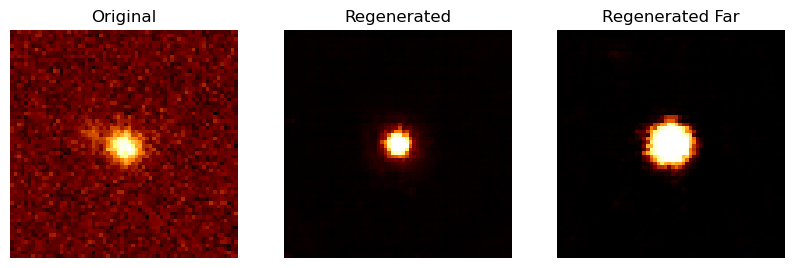

In [14]:
lib = 3
index = 466
z = test_gen[lib][0][1][index]
z_shifted = 2
band = 0
print(f'z = {z}')
str = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
str_shifted = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str_shifted = np.concatenate((str_shifted, np.array([z_shifted])))
str_shifted = str_shifted.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
axes[0].imshow(test_gen[lib][0][0][index][band], cmap = 'afmhot')
axes[1].imshow(decoder([str])[0][band], cmap = 'afmhot')
axes[2].imshow(decoder([str_shifted])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title("Original")
axes[1].set_title("Regenerated")
axes[2].set_title("Regenerated Far")
plt.show()

z = 0.447369993


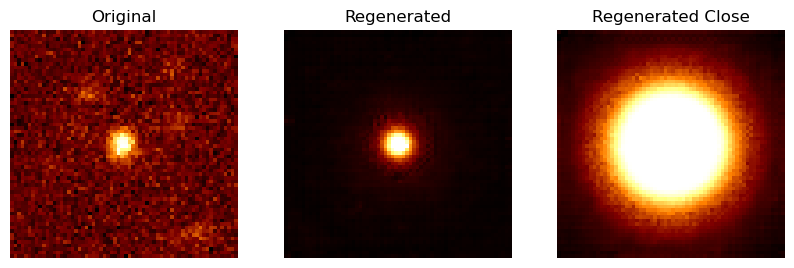

In [17]:
lib = 5
index = 273
z = test_gen[lib][0][1][index]
z_shifted = 0.1
band = 0
print(f'z = {z}')
str = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str = np.concatenate((str, np.array([z])))
str = str.reshape(1, LATENT_DIM + 1)
str_shifted = np.asarray(encoder([np.array([test_gen[lib][0][0][index]]), np.array([test_gen[lib][0][1][index]])])[0])
str_shifted = np.concatenate((str_shifted, np.array([z_shifted])))
str_shifted = str_shifted.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 3, figsize = (10, 5))
axes[0].imshow(test_gen[lib][0][0][index][band], cmap = 'afmhot')
axes[1].imshow(decoder([str])[0][band], cmap = 'afmhot')
axes[2].imshow(decoder([str_shifted])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[2].axis('off')
axes[0].set_title("Original")
axes[1].set_title("Regenerated")
axes[2].set_title("Regenerated Close")
plt.show()

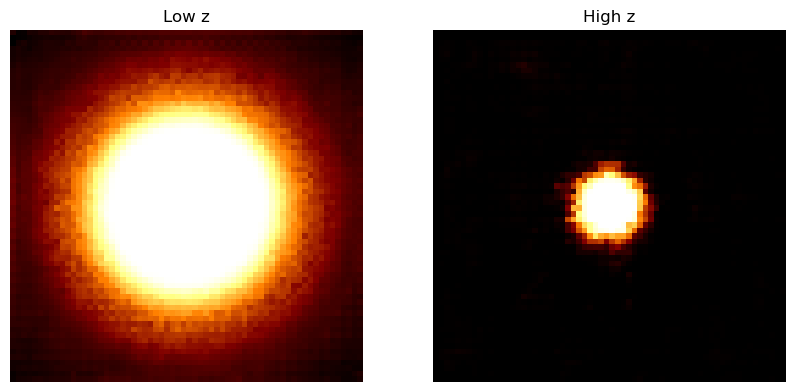

Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astro-data-lab/VAE/e/VAE-230/metadata


In [31]:
band = 0
str = prior.sample(1)[0]
strlo = np.concatenate((str, np.array([0.1])))
strlo = strlo.reshape(1, LATENT_DIM + 1)
strhi = np.concatenate((str, np.array([2])))
strhi = strhi.reshape(1, LATENT_DIM + 1)
fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
axes[0].imshow(decoder([strlo])[0][band], cmap = 'afmhot')
axes[1].imshow(decoder([strhi])[0][band], cmap = 'afmhot')
axes[0].axis('off')
axes[1].axis('off')
axes[0].set_title("Low z")
axes[1].set_title("High z")
plt.show()

fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 5))
x_array = np.arange(5)
lo_array = np.array([])
hi_array = np.array([])
for j in range(0, 5):
    lo_array = np.append(lo_array, decoder([strlo])[0][j][63][63])
    hi_array = np.append(hi_array, decoder([strhi])[0][j][63][63])
axes[0].scatter(x_array, lo_array, c = 'blue', label = 'Low')
axes[1].scatter(x_array, hi_array, c = 'red', label = 'High')
axes[0].set_xlabel("Bands")
axes[0].set_ylabel("Central Pixel Value")
axes[0].legend()
axes[1].legend()

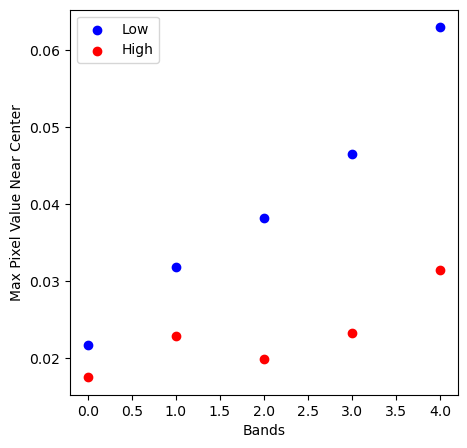

In [17]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
x_array = np.arange(5)
lo_array = np.array([])
hi_array = np.array([])
for j in range(0, 5):
    lo_array = np.append(lo_array, np.amax(np.transpose(np.asarray(decoder([strlo])[0][j][60:67]))[60:67].flatten()))
    hi_array = np.append(hi_array, np.amax(np.transpose(np.asarray(decoder([strhi])[0][j][60:67]))[60:67].flatten()))
axes.scatter(x_array, lo_array, c = 'blue', label = 'Low')
axes.scatter(x_array, hi_array, c = 'red', label = 'High')
axes.set_xlabel("Bands")
axes.set_ylabel("Max Pixel Value Near Center")
axes.legend()
axes.legend()

for j in range(3, 80):
    for i in range(0, 512):
        if test_gen[j][0][1][i] <= 0.1:
            print(j)
            print(i)

In [18]:
for j in range(3, 80):
    for i in range(0, 512):
        if test_gen[j][0][1][i] >= 3.5:
            print(j)
            print(i)

IndexError: index 487 is out of bounds for axis 0 with size 487

In [ ]:
for i in range(0, 84):
    l = 512
    if i == 83:
        l = 464
    for j in range(0, l):
        index = i * BATCH_SIZE + j + 1
        stdout.write("\rChecking %d samples of " % (index) + "42960")
        z = test_gen[i][0][1][j]
        str = np.asarray(encoder([np.array([test_gen[i][0][0][j]]), np.array([test_gen[i][0][1][j]])])[0])
        str = np.concatenate((str, np.array([z])))
        str = str.reshape(1, LATENT_DIM + 1)
        hdul = fits.PrimaryHDU(data = test_gen[i][0][0][j])
        string = f"/data/CVAE Generated/Full/Original Galaxy #{index}.fits"
        hdul.writeto(string, overwrite = True)
        hdul = fits.PrimaryHDU(data = decoder([str])[0])
        string = f"/data/CVAE Generated/Full/Reconstructed Galaxy #{index}.fits"
        hdul.writeto(string, overwrite = True)

In [ ]:
def scatter_bands_max_near_center(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.amax(np.array([test_gen[0][0][0][i][j]])))
            pred_array = np.append(pred_array, np.amax(np.transpose(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j][60:67]))[60:67].flatten()))
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f"Maximum normalized pixel value z = {np.array([test_gen[0][0][1][i]])[0]}")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def scatter_bands_max(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.amax(np.array([test_gen[0][0][0][i][j]])))
            pred_array = np.append(pred_array, np.amax(np.array([model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]])))
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel("Maximum normalized pixel value")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()
        
def scatter_bands_center(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_array = np.append(true_array, np.array([test_gen[0][0][0][i][j]])[0][63][63])
            pred_array = np.append(pred_array, model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j][63][63])
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel("Bands")
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f"Central pixel value z = {np.array([test_gen[0][0][1][i]])}")
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()
        
def scatter_bands_center_shift(lib = 3, i = 37, z = 1):
    print(z)
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
    x_array = np.arange(5)
    true_array = np.array([])
    pred_array = np.array([])
    for j in range(0, 5):
        true_array = np.append(true_array, np.array([test_gen[lib][0][0][i][j]])[0][63][63])
        pred_array = np.append(pred_array, model([np.array([test_gen[lib][0][0][i]]), np.array([z])])[0][j][63][63])
    axes.scatter(x_array, true_array, c = 'blue', label = 'True')
    axes.scatter(x_array, pred_array, c = 'red', label = 'Predicted')
    axes.set_xlabel("Bands")
    axes.set_ylabel("Central pixel value")
    axes.legend()
    
def scatter_bands_max_shift(lib = 3, i = 37, z = 1):
    print(z)
    fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5, 5))
    x_array = np.arange(5)
    true_array = np.array([])
    pred_array = np.array([])
    for j in range(0, 5):
        true_array = np.append(true_array, np.amax(np.array([test_gen[lib][0][0][i][j]])))
        pred_array = np.append(pred_array, np.amax(np.array([model([np.array([test_gen[lib][0][0][i]]), np.array([z])])[0][j]])))
    axes.scatter(x_array, true_array, c = 'blue', label = 'True')
    axes.scatter(x_array, pred_array, c = 'red', label = 'Predicted')
    axes.set_xlabel("Bands")
    axes.set_ylabel("Central pixel value")
    axes.legend()

def scatter_bands_percentile(percentile = 90, num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show /  5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_90 = np.percentile(np.array([test_gen[0][0][0][i][j]]).flatten(), percentile)
            pred_90 = np.percentile(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten(), percentile)
            true_array = np.append(true_array, true_90)
            pred_array = np.append(pred_array, pred_90)
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel('Bands')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel(f'{percentile}th percentile normalized pixel value')
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def scatter_bands_mean(num_to_show = 10, index = 0):
    fig, axes = plt.subplots(nrows = int(num_to_show / 5), ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        true_array = np.array([])
        pred_array = np.array([])
        for j in range(0, 5):
            true_mean = np.mean(np.array([test_gen[0][0][0][i][j]]).flatten())
            pred_mean = np.mean(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten())
            true_array = np.append(true_array, true_mean)
            pred_array = np.append(pred_array, pred_mean)
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, true_array, c = 'blue', label = 'True')
        axes[int((i - index) / 5)][int((i - index) % 5)].scatter(x_array, pred_array, c = 'red', label = 'Predicted')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_xlabel('Bands')
        axes[int((i - index) / 5)][int((i - index) % 5)].set_ylabel('Mean normalized pixel value')
        axes[int((i - index) / 5)][int((i - index) % 5)].legend()

def display_histograms(num_to_show = 2, index = 0):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, int(num_to_show)))
    for i in range(index, index + num_to_show):
        x_array = np.arange(5)
        for j in range(0, 5):
            true_arr = sorted(np.array([test_gen[0][0][0][i][j]]).flatten())
            pred_arr = sorted(np.asarray(model([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])])[0][j]).flatten())
            true_arr = true_arr[0 : int(len(true_arr) * .99)]
            pred_arr = pred_arr[0 : int(len(pred_arr) * .99)]
            axes[i][j].hist(true_arr, 100, color = 'blue', label = 'True', alpha = 0.5)
            axes[i][j].hist(pred_arr, 100, color = 'red', label = 'Predicted', alpha = 0.5)
            axes[i][j].set_xlabel("Pixel Values")
            axes[i][j].set_ylabel("Count")
            axes[i][j].legend()
    fig.suptitle('Histograms of Predicted vs. True Image, Horizontal are Bands')
    
def display_5_bands(index):
    fig, axes = plt.subplots(nrows = 2, ncols = 5, figsize = (20, 10))
    loss = round(model.evaluate([np.array([test_gen[0][0][0][index]]), np.array([test_gen[0][0][1][index]])], np.array([test_gen[0][0][0][index]]), verbose = 0), 2)
    for i in range(0, 5):
        axes[0][i].imshow(np.array([test_gen[0][0][0][index]])[0][i], cmap = 'afmhot')
        max_pixel_true = round(np.amax(np.array([test_gen[0][0][0][index]])[0][i]), 2)
        # axes[0][i].set_title(f'True band {i} max = {max_pixel_true}')
        pred = model([np.array([test_gen[0][0][0][index]]), np.array([test_gen[0][0][1][index]])])[0][i]
        axes[1][i].imshow(pred, cmap = 'afmhot')
        max_pixel_pred = round(np.amax(pred), 2)
        axes[1][i].set_title(f'\n loss = {loss}') # f'Pred band {i} max = {max_pixel_pred}' + 
        
def display_high_loss(num_to_show, min_loss):
    fig, axes = plt.subplots(nrows = num_to_show, ncols = 5, figsize = (20, 5 * num_to_show))
    r = 0
    for i in range(BATCH_SIZE):
        loss = round(model.evaluate([np.array([test_gen[0][0][0][i]]), np.array([test_gen[0][0][1][i]])], np.array([test_gen[0][0][0][i]]), verbose = 0), 2)
        if loss >= min_loss:
            print(i)
            for j in range(0, 5):
                axes[r][j].imshow(np.array([test_gen[0][0][0][i]])[0][j], cmap = 'afmhot')
                axes[r][j].set_title(f'Loss = {loss}')
            r += 1
        if r >= num_to_show:
            break

In [ ]:
scatter_bands_max_near_center(num_to_show = 10, index = 10)

In [ ]:
x_array = np.array([])
y_array = np.array([])
l = len(test_gen[0][0][0])
print(l)
for i in range(0, l):
    x_array = np.append(x_array, np.amax(np.array([test_gen[0][0][0][i][4]])))
    y_array = np.append(y_array, np.array([test_gen[0][0][1][i]])[0])
    print(i)
plt.scatter(y_array, x_array)

In [ ]:
from scipy.stats import gaussian_kde
xy = np.asarray(np.vstack([y_array, x_array])).astype('float32')
z = gaussian_kde(xy)(xy)
plt.scatter(y_array, x_array, s = 5, c = z)
plt.xlim(0,4)
plt.ylim(0, 80)
plt.xlabel("z")
plt.ylabel("Maximum Pixel Value near the Center")
plt.show()

In [ ]:
scatter_bands_center_shift(lib = 3, i = 267, z = 40)

In [ ]:
scatter_bands_max_shift(lib = 3, i = 37, z = test_gen[3][0][1][37])

In [ ]:
scatter_bands_max_shift(lib = 3, i = 37, z = 0.1)

In [ ]:
scatter_bands_max()

In [ ]:
scatter_bands_center()

In [ ]:
scatter_bands_mean(10, 0)

In [ ]:
scatter_bands_percentile()

In [ ]:
# display_histograms()

In [ ]:
display_5_bands(38)

In [ ]:
display_high_loss(10, 1)

In [ ]:
from tqdm import tqdm

In [27]:
hf = h5py.File('/data3/Billy/64x64_cvae_generated_15.hdf5', 'a')
str = prior.sample(1)[0]
str = np.concatenate((str, np.array([0.1])))
str = str.reshape(1, LATENT_DIM + 1)
image_g = decoder([str])[0][0]
image_r = decoder([str])[0][1]
image_i = decoder([str])[0][2]
image_z = decoder([str])[0][3]
image_y = decoder([str])[0][4]
five_band_image = []
five_band_image.append(image_g)
five_band_image.append(image_r)
five_band_image.append(image_i)
five_band_image.append(image_z)
five_band_image.append(image_y)
five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
hf.create_dataset('image', data = five_band_image_reshape, chunks = True, maxshape = (None, 5, 64, 64))
hf.create_dataset('specz_redshift', data = [0.1], chunks = True, maxshape = (None, ))
for i in tqdm(range(1999)):
    z = random.uniform(0, 2)
    str = prior.sample(1)[0]
    str = np.concatenate((str, np.array([z])))
    str = str.reshape(1, LATENT_DIM + 1)
    image_g = decoder([str])[0][0]
    image_r = decoder([str])[0][1]
    image_i = decoder([str])[0][2]
    image_z = decoder([str])[0][3]
    image_y = decoder([str])[0][4]
    five_band_image = []
    five_band_image.append(image_g)
    five_band_image.append(image_r)
    five_band_image.append(image_i)
    five_band_image.append(image_z)
    five_band_image.append(image_y)
    five_band_image_reshape = np.reshape(np.array(five_band_image), [1, 5, 64, 64])
    hf['specz_redshift'].resize((hf['specz_redshift'].shape[0] + 1), axis = 0)
    hf['specz_redshift'][hf['specz_redshift'].shape[0] - 1] = [z]
    hf['image'].resize((hf['image'].shape[0] + 1), axis = 0)
    hf['image'][hf['image'].shape[0] - 1, :, :, :] = five_band_image
hf.close()

100%|██████████| 1999/1999 [02:12<00:00, 15.03it/s]


Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astro-data-lab/VAE/e/VAE-226/metadata
Shutting down background jobs, please wait a moment...
Done!
All 0 operations synced, thanks for waiting!
Explore the metadata in the Neptune app:
https://app.neptune.ai/astro-data-lab/VAE/e/VAE-225/metadata


In [ ]:
# END